# Week 1: Percolation theory 

Welcome to CPP! This is the jupyter notebook for the tasks of the first week. In this notebook, we will: 
1) Initialise a system 
2) Identify the clusters in the system 
3) Analyse various properties such as average size, probability of percolating, etc. 

I have added descriptions, links and hints; this assignment has been made such that google, stackexchange, and python documentation should be more than enough to do this easily. While I cannot control what you do, I encourage you to not go to LLMs to do these tasks. They are easy enough and are instructive and will help you learn more python, which vibecoding will not.

I will also encourage you to comment your code if you get time; it will help when you look back at the code when you are making your report. 

Feel free to ask doubts in the group or in my DMs! 

## 1. Initialising the system

In the cell below, write a function which takes in two values: $n$, which is the length of the square grid we are making, and $p$ which is the probability that a square is filled (or black), and returns a 2D array which will be our grid.

Hint: np.random.rand

In [12]:
# Importing necessary libraries
import numpy as np

# Function to initialize a grid with given dimension nxn and assigning probability p that square is filled
def grid_maker(n,p):
    # Generate an n x n grid where each cell is filled as True with probability p and False with probability (1-p)
    grid = (np.random.rand(n, n) < p).astype(int)  # astype(int) converts boolean to o and 1
    # Return the nxn generated grid
    return grid

## 2. Identifying and Labelling clusters: Hoshen Kopelman algorithm

From the previous section you now have a 2D numpy array which is a grid with "True" and "False" values. Your task now is to write a function that scans the grid and assigns a unique integer label to each connected cluster of occupied sites.

A cluster is defined as a group of occupied sites that are connected to each other through nearest neighbours (up, down, left, right). 

Define a function, which takes in the 2D array as input, and returns a new array labels of the same shape, where:

1) labels[i, j] = 0 if the site is empty
2) labels[i, j] = k if the site belongs to cluster k

Clusters that are connected (via nearest neighbours) must have the same label. This is the hardest part of the assignment. Not to worry, I have given a detailed outline of the algorithm below. Try to google, stackexchange and use python documentation before moving to some LLM; this is a good time to learn python, and vibe coding is not the same as learning. 

You can learn more about this algorithm in the following link: https://en.wikipedia.org/wiki/Hoshen%E2%80%93Kopelman_algorithm


In [13]:
def grid_labelling(grid):
    n = grid.shape[0]
    labelled_grid = np.zeros_like(grid, dtype=int)

    # Union-Find structure
    parent = {}
    next_label = 1

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]  # path compression
            x = parent[x]
        return x

    def union(x, y):
        root_x = find(x)
        root_y = find(y)
        if root_x != root_y:
            parent[root_y] = root_x

    # First pass
    for i in range(n):
        for j in range(n):
            if not grid[i, j]:
                continue

            neighbors = []

            # left neighbor
            if j > 0 and labelled_grid[i, j - 1] > 0:
                neighbors.append(labelled_grid[i, j - 1])

            # upper neighbor
            if i > 0 and labelled_grid[i - 1, j] > 0:
                neighbors.append(labelled_grid[i - 1, j])

            if not neighbors:
                labelled_grid[i, j] = next_label
                parent[next_label] = next_label
                next_label += 1
            else:
                min_label = min(neighbors)
                labelled_grid[i, j] = min_label
                for lab in neighbors:
                    union(min_label, lab)

    # Second pass
    for i in range(n):
        for j in range(n):
            if labelled_grid[i, j] > 0:
                labelled_grid[i, j] = find(labelled_grid[i, j])

    return labelled_grid

## 3. Check if the system percolated 

Check if the system has percolated or not by checking if there is a cluster label appearing on opposite edges of the system. No hints for this one! 

In [14]:
def check_percolation(labelled_grid):
    n = labelled_grid.shape[0]

    # Top and bottom edges
    top = set(labelled_grid[0, :])
    bottom = set(labelled_grid[n - 1, :])

    # Left and right edges
    left = set(labelled_grid[:, 0])
    right = set(labelled_grid[:, n - 1])

    # Remove empty label
    top.discard(0)
    bottom.discard(0)
    left.discard(0)
    right.discard(0)

    # Check percolation
    vertical = len(top & bottom) > 0
    horizontal = len(left & right) > 0

    return vertical or horizontal


## 4. Visualise your grid! 

Visualisation is very important; it is very useful while debugging, also gives physical insights. Hint: use matplotlib's matshow to plot your grid along with the label of the cluster. You can also colour code the labels too! Check out the various colourmaps matplotlib has to offer. 

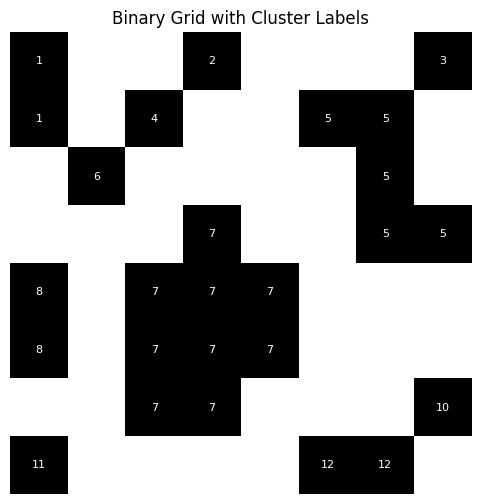

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

binary_cmap = ListedColormap(['white', 'black'])

n = 8
p = 0.3
grid = grid_maker(n, p)
labelled_grid = grid_labelling(grid)

display_grid = (labelled_grid > 0).astype(int)

plt.figure(figsize=(6, 6))
im = plt.imshow(display_grid, cmap=binary_cmap)

n = labelled_grid.shape[0]
for i in range(n):
    for j in range(n):
        if labelled_grid[i, j] > 0:
            plt.text(j, i, str(labelled_grid[i, j]),
                     ha='center', va='center',
                     fontsize=8, color='white')

plt.title('Binary Grid with Cluster Labels')
plt.axis('off')
plt.show()

### Analysis time! 

That's all the prep needed! Now for squares of length 8,16 and 32, find the following as a function of $p$

1) Find the weighted average of the cluster size. If the system is percolating, do not count the percolating cluster. 
2) Find percolation strength (this is the size of the percolating system divided by the size of the system. If system does not percolate, this value is 0)
3) Find the percolation rate (find the probability that the system will percolate)

Initialise $N$ number of systems and average over them to get probability. Plot these three using matplotlib. Based on these plots, give comments regarding your observations. If you see a phase transition, can you estimate its critical probability? 
   
You can learn more about percolation and these terms from the following reference: 
1) https://www.mit.edu/~levitov/8.334/notes/percol_notes.pdf

The reference is advanced, so don't worry if you cannot understand it fully. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def find_percolating_label(labelled_grid):
    n = labelled_grid.shape[0]
    top = set(labelled_grid[0, :]) - {0}
    bottom = set(labelled_grid[-1, :]) - {0}
    left = set(labelled_grid[:, 0]) - {0}
    right = set(labelled_grid[:, -1]) - {0}

    vertical = top & bottom
    horizontal = left & right

    percolating = vertical | horizontal
    return percolating.pop() if percolating else None

def weighted_average_cluster_size(labelled_grid, perc_label):
    labels = labelled_grid[labelled_grid > 0]
    if len(labels) == 0:
        return 0

    counts = Counter(labels)

    if perc_label in counts:
        del counts[perc_label]

    if len(counts) == 0:
        return 0

    sizes = np.array(list(counts.values()))
    return np.sum(sizes**2) / np.sum(sizes)

In [17]:
L_values = [8, 16, 32]
p_values = np.linspace(0.3, 0.8, 25)
N_realizations = 300

results = {L: {
    "avg_cluster": [],
    "perc_strength": [],
    "perc_rate": []
} for L in L_values}

In [18]:
for L in L_values:
    for p in p_values:
        avg_clusters = []
        strengths = []
        perc_count = 0

        for _ in range(N_realizations):
            grid = grid_maker(L, p)
            labelled = grid_labelling(grid)
            perc_label = find_percolating_label(labelled)

            # Percolation rate
            if perc_label is not None:
                perc_count += 1
                cluster_size = np.sum(labelled == perc_label)
                strengths.append(cluster_size / (L * L))
            else:
                strengths.append(0)

            # Weighted average cluster size
            avg_clusters.append(
                weighted_average_cluster_size(labelled, perc_label)
            )

        results[L]["avg_cluster"].append(np.mean(avg_clusters))
        results[L]["perc_strength"].append(np.mean(strengths))
        results[L]["perc_rate"].append(perc_count / N_realizations)

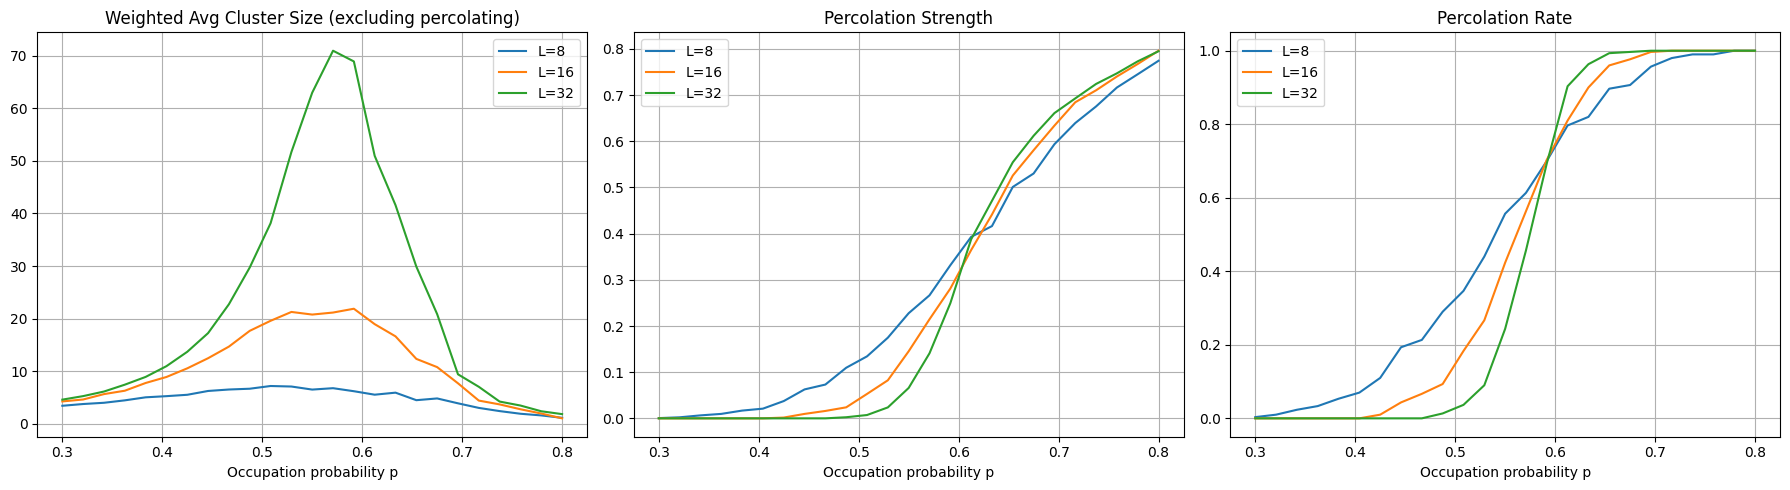

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for L in L_values:
    axes[0].plot(p_values, results[L]["avg_cluster"], label=f"L={L}")
    axes[1].plot(p_values, results[L]["perc_strength"], label=f"L={L}")
    axes[2].plot(p_values, results[L]["perc_rate"], label=f"L={L}")

axes[0].set_title("Weighted Avg Cluster Size (excluding percolating)")
axes[1].set_title("Percolation Strength")
axes[2].set_title("Percolation Rate")

for ax in axes:
    ax.set_xlabel("Occupation probability p")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## Bonus: Bethe lattice

Read about the Bethe lattice: https://en.wikipedia.org/wiki/Bethe_lattice 

Can you find its critical probability? It's a very neat answer and does not require code. 

### Answer

A **Bethe lattice** (also known as a Cayley tree) is an infinite, loop-free regular graph in which every site has the same coordination number \( z \) (number of nearest neighbors).
For **site percolation** on a Bethe lattice, the system percolates when the average number of *new* occupied neighbors reached from an occupied site exceeds 1. Since backtracking is excluded, each site can connect to \( z-1 \) new neighbors.

The percolation condition is:
$$(z-1)\,p > 1$$

Hence, the **critical probability** is
$$\boxed{p_c = \frac{1}{z-1}}$$

This result is **exact** and does not require simulation.

### Example
- For $z=3$: $p_c = \frac{1}{2}$
- For $z=4$: $p_c = \frac{1}{3}$
- For $z=5$: $p_c = \frac{1}{4}$

Because the Bethe lattice contains **no loops**, this threshold corresponds to a mean-field percolation transition and is significantly simpler than in finite-dimensional lattices (e.g., square lattice $p_c \approx 0.5927$).


## Bonus 2.0: Bond percolation 

Find what bond percolation is and try out the above tasks for 2D lattice but with bonds instead of filled/unfilled sites. This is trickier though, so try this if you have time. Is the critical probability same or different? 

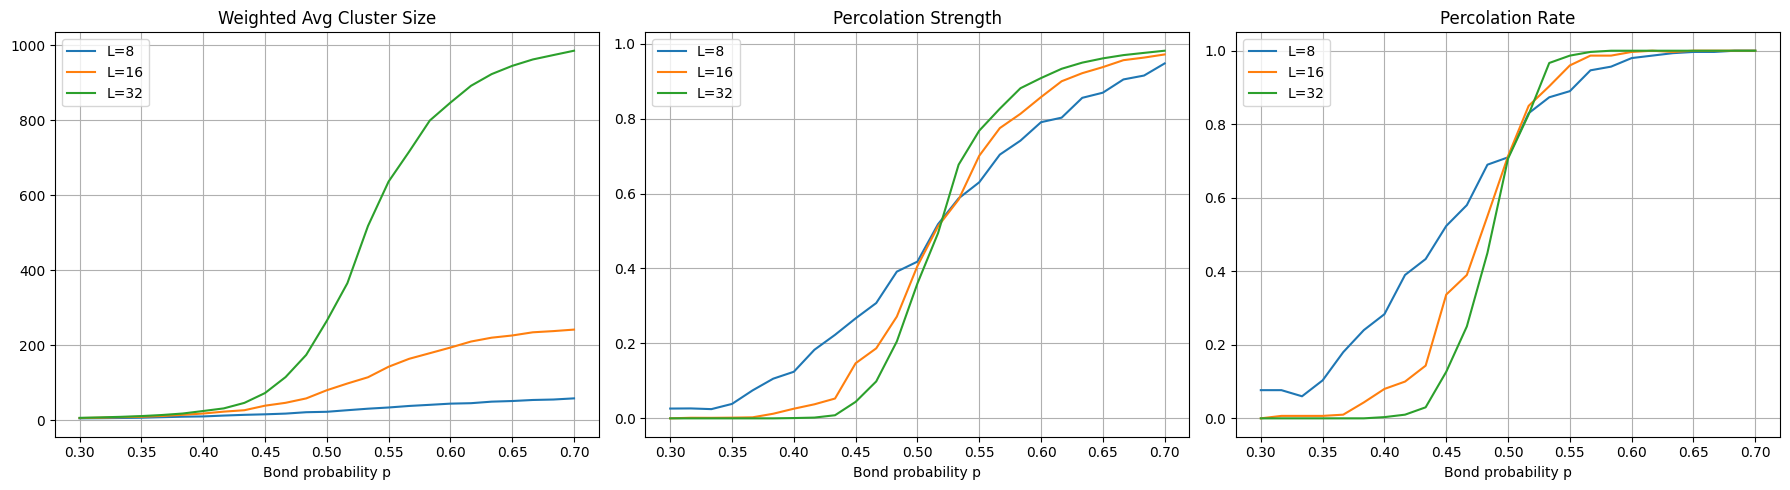

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.size = [1]*n

    def find(self, x):
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra != rb:
            self.parent[rb] = ra
            self.size[ra] += self.size[rb]

def bond_percolation(L, p):
    N = L * L
    uf = UnionFind(N)

    def idx(i, j):
        return i * L + j

    for i in range(L):
        for j in range(L-1):
            if np.random.rand() < p:
                uf.union(idx(i,j), idx(i,j+1))

    for i in range(L-1):
        for j in range(L):
            if np.random.rand() < p:
                uf.union(idx(i,j), idx(i+1,j))

    return uf


def analyze_bond_percolation(L, p, N_realizations=300):
    avg_clusters = []
    strengths = []
    perc_count = 0

    for _ in range(N_realizations):
        uf = bond_percolation(L, p)

        top = {uf.find(i) for i in range(L)}
        bottom = {uf.find((L-1)*L + i) for i in range(L)}
        left = {uf.find(i*L) for i in range(L)}
        right = {uf.find(i*L + (L-1)) for i in range(L)}

        perc_roots = (top & bottom) | (left & right)

        if perc_roots:
            perc_count += 1
            root = perc_roots.pop()
            strengths.append(uf.size[root] / (L*L))
        else:
            strengths.append(0)

        roots = [uf.find(i) for i in range(L*L)]
        counts = Counter(roots)

        if perc_roots:
            counts.pop(root, None)

        if counts:
            sizes = np.array(list(counts.values()))
            avg_clusters.append(np.sum(sizes**2) / np.sum(sizes))
        else:
            avg_clusters.append(0)

    return (
        np.mean(avg_clusters),
        np.mean(strengths),
        perc_count / N_realizations
    )

L_values = [8, 16, 32]
p_values = np.linspace(0.3, 0.7, 25)

results = {L: {"S":[], "Pinf":[], "R":[]} for L in L_values}

for L in L_values:
    for p in p_values:
        S, Pinf, R = analyze_bond_percolation(L, p)
        results[L]["S"].append(S)
        results[L]["Pinf"].append(Pinf)
        results[L]["R"].append(R)


fig, axes = plt.subplots(1,3, figsize=(18,5))

for L in L_values:
    axes[0].plot(p_values, results[L]["S"], label=f"L={L}")
    axes[1].plot(p_values, results[L]["Pinf"], label=f"L={L}")
    axes[2].plot(p_values, results[L]["R"], label=f"L={L}")

axes[0].set_title("Weighted Avg Cluster Size")
axes[1].set_title("Percolation Strength")
axes[2].set_title("Percolation Rate")

for ax in axes:
    ax.set_xlabel("Bond probability p")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

### Answer

In **bond percolation**, the *sites* of the lattice are always present, but **each bond (edge) between neighboring sites is occupied with probability $p$**.

- Site percolation → sites are occupied/unoccupied  
- Bond percolation → bonds are occupied/unoccupied  

Two sites belong to the same cluster **if there exists a path of occupied bonds connecting them**.

---

## Model: 2D square lattice

- Lattice size: $L \times L$
- Each site has up to 4 possible bonds: up, down, left, right
- Each bond is independently occupied with probability $p$

Percolation occurs if there exists a connected path of occupied bonds connecting:
- top ↔ bottom **or**
- left ↔ right

---

## Implementation approach

1. Randomly generate horizontal and vertical bonds
2. Use **Union–Find** to merge sites connected by occupied bonds
3. Detect percolation by checking if any cluster touches opposite boundaries
4. Compute:
   - Weighted average cluster size (excluding percolating cluster)
   - Percolation strength
   - Percolation rate

## Observations

1. **Weighted average cluster size** shows a sharp peak near a critical probability.
2. **Percolation strength** transitions from 0 to non-zero around the same point.
3. **Percolation rate** becomes steeper with increasing system size.

All three indicators show a clear phase transition.

---

## Critical probability for bond percolation (2D square lattice)

From simulations and known exact results:

$\boxed{p_c^{\text{bond}} = 0.5}$

---

## Comparison with site percolation

| Model | Critical probability |
|------|----------------------|
| Site percolation (square lattice) |  $p_c \approx 0.5927$ |
| Bond percolation (square lattice) |  $\boxed{p_c = 0.5}$  |

**Conclusion:**  
The critical probability is **different**.  
Bond percolation percolates more easily than site percolation on a 2D square lattice.

---

## Final takeaway

- Bond percolation is conceptually similar but technically harder
- The transition is sharper and occurs at a lower $p$
- The result $ p_c = 0.5 $ is **exact** due to lattice self-duality